A blockchain is a distributed database with a list (that is, chain) of records (that is, blocks) linked and secured by digital fingerprints (that is, cryptho hashes).

In simple words, we have a series of blocks where each block contains specific transaction information like transaction id.

Each block in the blockchain is connected to the next block through a pre-computed hash function.


A blockchain uses the 



*   block timestamp and
*   the hash from the previous block and
*   the block data (e.g. Transaction Data)
to calculate the new hash digest checksum

### Security in Blockchain

Since blockhain contains important information about transaction, it is important to look into the security of such transaction.

Because blockchain uses consensus algorithm to verify transactions, it is impossible for a single unit to pose a threat to the data network. A node (or unit) that begins to act abnormally can easily be identified and expunged from the network.

### Problem Statement

Based on the transactions of the distributed registry of Bitcoin, to identify the moments of abnormal behavior and transactions in the market, from September to December 2018.


### Problem Solution

To detect such anomalies in transactions through different outlier detection algorithm.


In [0]:
from __future__ import absolute_import


from google.cloud import bigquery
from sklearn.ensemble import IsolationForest
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Since our dataset is hosted on the google cloud platform, we need to have the required credentials in order to be able to fetch data from the platform and run it here.

We therefore use "My Project 45219-41629692d3a0.json" which is the credential used to login into the cloud platform and fetch the data.

In [0]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']="/content/My Project 45219-41629692d3a0.json"
client = bigquery.Client()

In [0]:
query = """
SELECT DATE((timestamp)) AS date,
        COUNT(number) AS blocks
FROM `bigquery-public-data.crypto_bitcoin.blocks`
GROUP BY date
HAVING date >= '2018-09-01' AND date <= '2018-12-31'
ORDER BY date

"""

In [0]:
query_job = client.query(query)
# Waits for the query to finish
iterator = query_job.result(timeout=30)
rows = list(iterator)
df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

In [82]:

df.head()


,date,blocks
0,2018-09-01,151
1,2018-09-02,144
2,2018-09-03,144
3,2018-09-04,126
4,2018-09-05,132


Text(0.5,1,'Blocks per day')

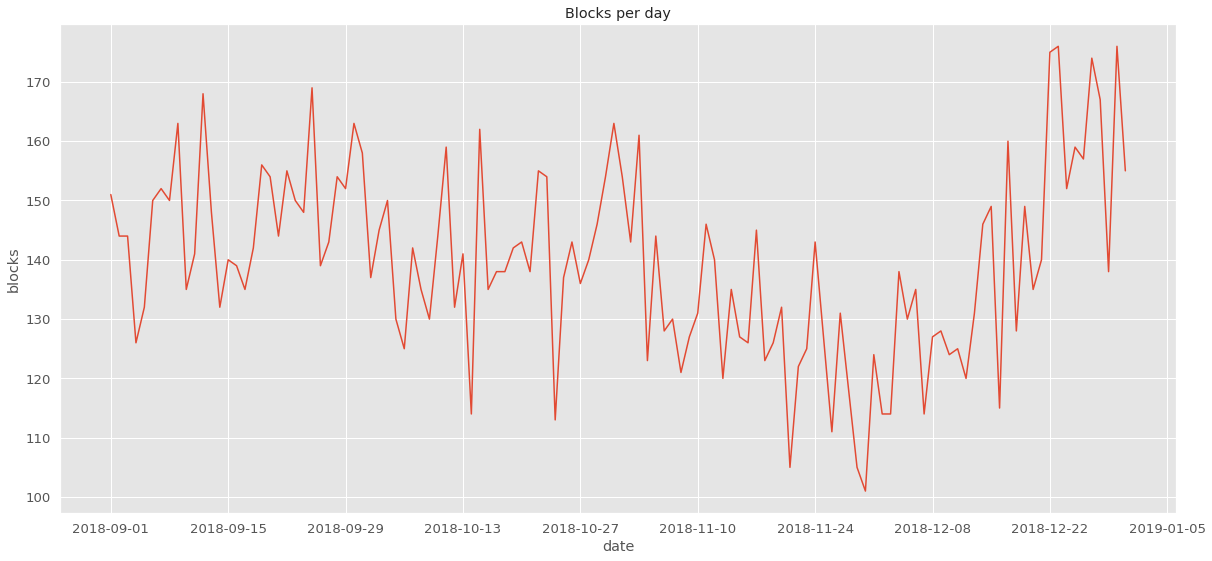

In [83]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='date', y='blocks', data=df, palette='Blues_b')
plt.title('Blocks per day')

Based on the data obtained, we can say that at the end of 2018 the volume of transactions went down (moreover, at the end of November it reached an extremely low level):

In [0]:
query_2 = """
SELECT
  o.date,
  SUM(o.output_price) AS sum_output_price,
  COUNT(o.block) AS blocks
FROM (
  SELECT
    DATE((block_timestamp)) AS date,
    output.value AS output_price,
    block_number AS block
  FROM
    `bigquery-public-data.crypto_bitcoin.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  o.date
HAVING o.date >= '2018-09-01' AND o.date <= '2018-12-31'
ORDER BY o.date, blocks
"""
query_job_2 = client.query(query_2)
# Waits for the query to finish
iterator_2 = query_job_2.result(timeout=30)
rows_2 = list(iterator_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))

df_2["sum_output_price"]= df_2["sum_output_price"].apply(lambda x: float(x/100000000))

In [85]:
df_2.head()


,date,sum_output_price,blocks
0,2018-09-01,881906.292395,565645
1,2018-09-02,827630.138096,491490
2,2018-09-03,924600.635920,575316
3,2018-09-04,936828.266644,596961
4,2018-09-05,963010.475818,633097


Text(0.5,1,'Sum of all satoshis spent each day')

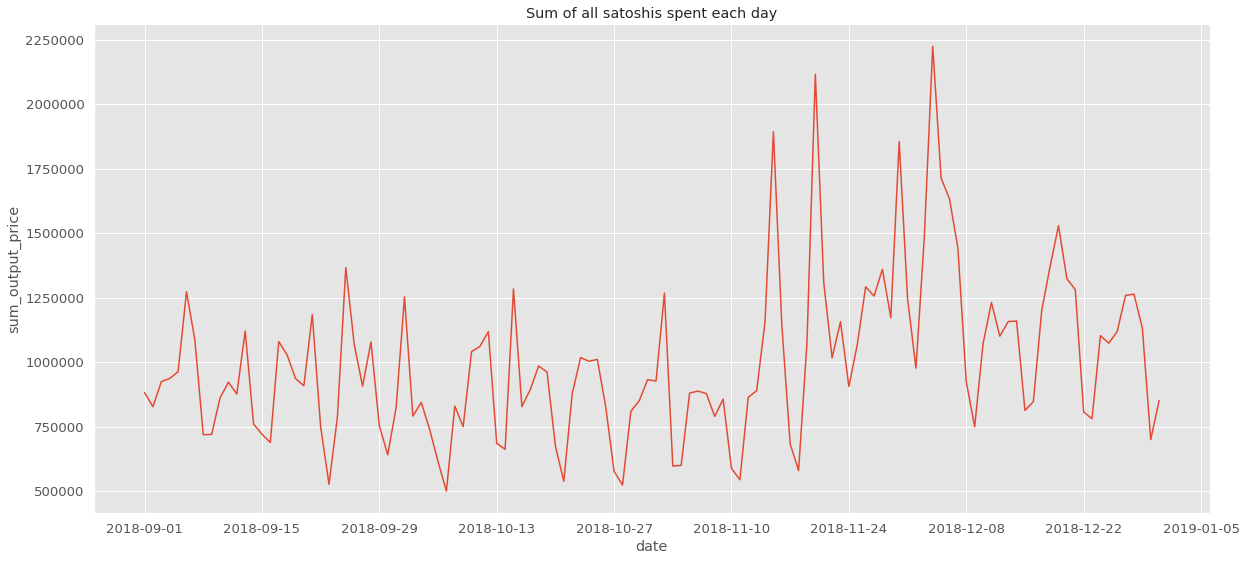

In [86]:
g_2 = plt.subplots(figsize=(20,9))
g_2 = sns.lineplot(x='date', y='sum_output_price', data=df_2, palette='BuGn_r')
plt.title('Sum of all satoshis spent each day')

Now let's look at how the cost per byte in Satoshi has changed over the entire period under consideration. It is clearly seen that the price soared “at the end” of 2018 -
between November and December first week.


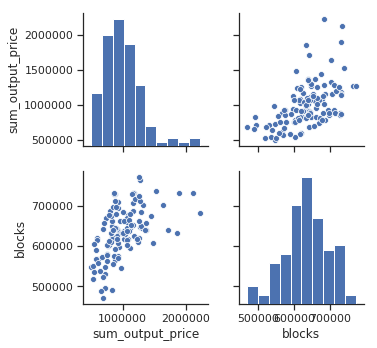

In [87]:
sns.set(style="ticks")
sns.pairplot(df_2)

We will group the data by the date the blocks were created and look at the ratio “quantity created to value”. We can notice that at some point the cost almost doubled.

We first try to detect such anomaly in the transaction data through outlier detection algorithm like Isolation Forest.


### Outlier Ensembles Based Model

### Isolation Forest

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


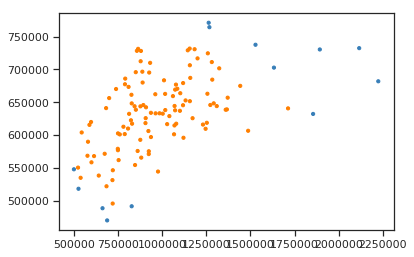

In [88]:

X = df_2.iloc[:,1:3].values
 
ifr = IsolationForest(contamination=0.1, random_state=42) 
y_pred = ifr.fit_predict(X)
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

In [89]:
y_pred  # 1 means normal value, -1 means anomalous value

array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1])

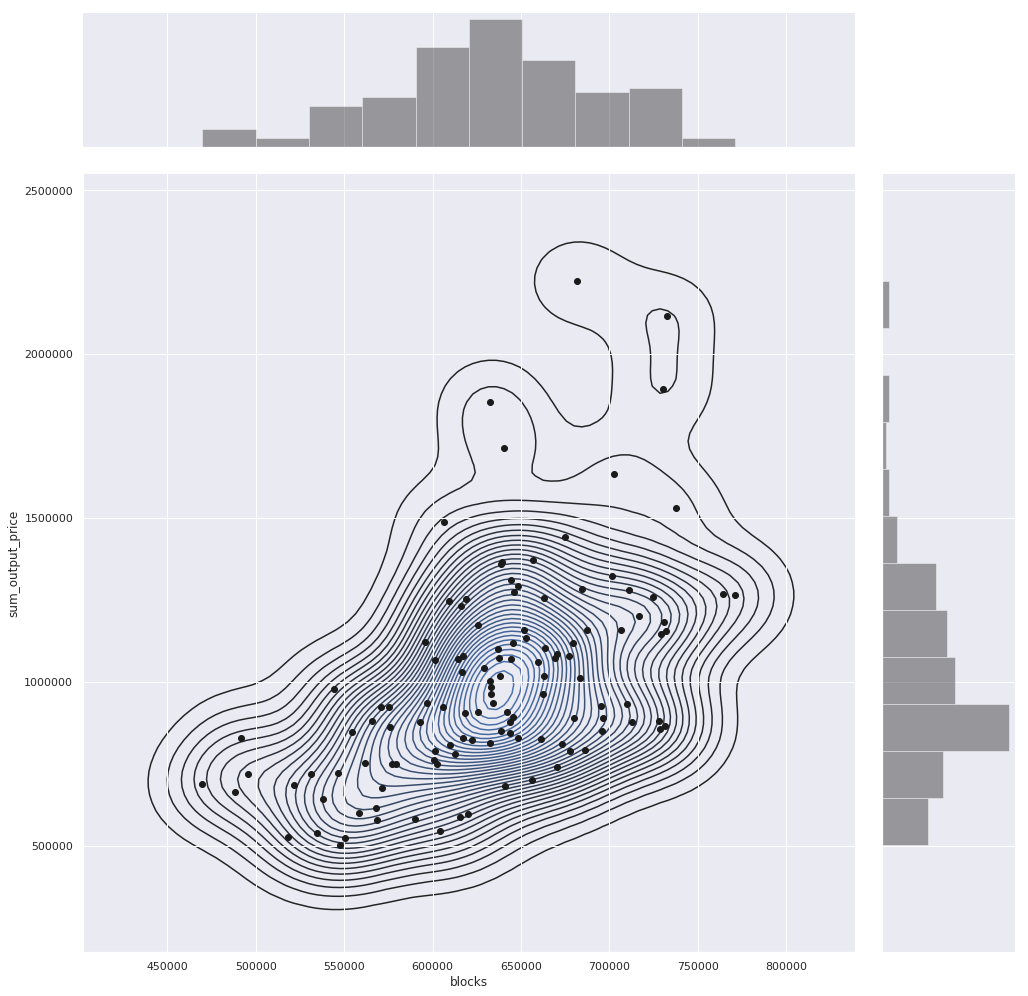

In [90]:
sns.set(style="darkgrid")
g_3 = sns.jointplot("blocks", "sum_output_price", data=df_2,  height=14, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=40)


This graph clearly demonstrates anomalies, that is, moments when the cost was extremely high in relation to the "normal" cost.


Now we try out with some other outlier detection algorithms and check which gives us better results for outlier detection.

Hence, we use a library called **pyod** which hosts a number of outlier detection algorithms.

In [91]:
pip install pyod

### KNN Classifier  (Proximity-Based)

In [92]:
from pyod.models.knn import KNN   # kNN detector

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [0]:
y_pred = clf.predict(X)  # outlier labels (0 or 1)
y_scores = clf.decision_function(X)  # outlier scores

In [94]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

0 means normal value while 1 means anomalous value.

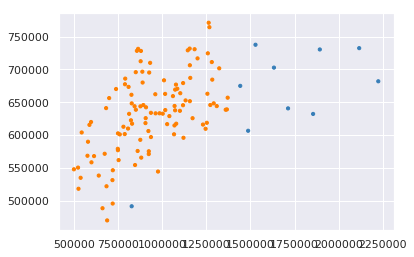

In [95]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred - 1) // 2])

Finding the ROC Accuracy score for the prediction label.

In [96]:
clf.fit_predict_score(X[:, 0].reshape(-1,1), y_pred, scoring='roc_auc_score')

roc_auc_score: 0.937946428571


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fit_predict_score is deprecated
  warnings.warn(msg, category=DeprecationWarning)


0.9379464285714286

### Angle-based Outlier Detector (Probabilistic Based Model)

In [0]:
from pyod.models import abod

In [98]:
clf_abod = abod.ABOD(contamination=0.1, n_neighbors=5, method='fast')
clf_abod.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [0]:
y_pred = clf_abod.predict(X)  # outlier labels (0 or 1)
y_scores = clf_abod.decision_function(X)  # outlier scores

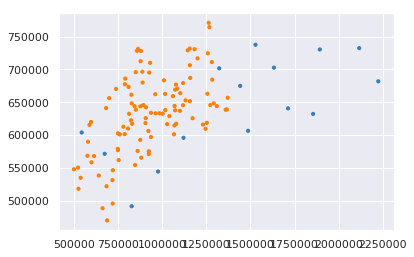

In [100]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred - 1) // 2])

In [101]:
clf_abod.fit_predict_score(X[:, 0].reshape(-1,1), y_pred, scoring='roc_auc_score')

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fit_predict_score is deprecated
  warnings.warn(msg, category=DeprecationWarning)


roc_auc_score: 0.864174454829


0.8641744548286605

### Linear Model PCA

In [0]:
from pyod.models.pca import PCA

In [103]:
clf_pca = PCA()
clf_pca.fit(X)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [0]:
y_pred = clf_pca.predict(X)  # outlier labels (0 or 1)
y_scores = clf_pca.decision_function(X)  # outlier scores

In [105]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

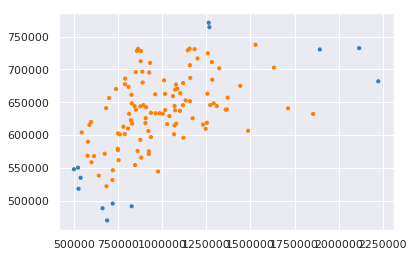

In [106]:
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred - 1) // 2])

In [107]:
clf_pca.fit_predict_score(X[:, 0].reshape(-1,1), y_pred, scoring='roc_auc_score')

roc_auc_score: 0.800988002823


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fit_predict_score is deprecated
  warnings.warn(msg, category=DeprecationWarning)


0.8009880028228652